# Real-Time Optimization
## Modifier Adaptation with Bayesian Optimization using EIC acquisition
### Preliminary thesis results

In [1]:
# Loading the necessary packages
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
from sklearn.utils import Bunch

plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = "dotted"

logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.ticker').disabled = True
logging.getLogger('matplotlib.colorbar').disabled = True
logging.basicConfig(level=logging.ERROR)

from rto.models.williams_otto import WilliamsOttoReactor, WilliamsOttoReactorSimplified
from rto.optimization.optimizer import ModifierAdaptationOptimizer, ModelBasedOptimizer
from rto.optimization.bayesian import ModelBasedBayesianOptimizer
from rto.rto import RTOBayesian, RTO
from rto.adaptation.ma_gaussian_processes import MAGaussianProcesses
from rto.utils import generate_samples_uniform
from rto.experiment.analysis import ExperimentAnalyzer

DATABASE = "/mnt/d/rto_data/thesis-analysis-01.db"

## Problem Description
The Williams-Otto CSTR is a benchmark process for real-time optimization (RTO) systems. It consists in the following reactions:

$ A + B \rightarrow C $ (1) 

$ B + C \rightarrow P + E $ (2) 

$ C + P \rightarrow G $ (3) 

where A and B are raw materials, P is the desired product, E is the byproduct with added sales value, C is the complex intermediate without sale value, and G is the residual material. The reactor is fed by two reactant flow rates (Fa and Fb). The full set of mass balance equations can be found in [1], for example.

Each reaction has its rate $k$ defined as a function of the reactor temperature Tr:

$ k_1 = 1.6599\times10^6\exp(-6666.7/Tr) $

$ k_2 = 7.2177\times10^8\exp(-8333.3/Tr) $ 

$ k_3 = 2.6745\times10^{12}\exp(-11111/Tr) $


Fa assumes a fixed, therefore Fb and Tr are our manipulated (decision) variables, $u=[Fb, Tr]$. The optimization objective is finding a combination of these variables in order to maximize the profit when the system reaches steady-state operation:

$ \Phi(u) = 1043.38*Xp*(Fa+Fb)+20.92*Xe*(Fa+Fb) - 79.23*Fa - 118.34*Fb$

where $Xp$ and $Xe$ are the amount of P and E in steady-state operation, respectively. Besides steady-state operation, the following operational constraints are enforced:

$Fb \in [3,6]$

$Tr \in [70, 100]$

$Xa < 0.12$
 
$Xg < 0.08$

In practice, however, it is very unlikely to know the complete model of a given process. It can be in the form of parametrical and/or structural mismatch. Parametrical mismatch means we know the model structure, but its parameters are uncertain. Structural mismatch is the case where we the complete model equations are unknown, which usually happens when trying to model complex processes and have to apply simplifications to some of its behaviors. It is easy to see that if we try to optimize a process based on a uncertain model, we can produce sub-optimal or even unfeasible operating points. This is where RTO systems come to the rescue: they are specifically designed to handle model uncertainty and lead to process optimality under convergence.

For the Williams-Otto CSTR we know all the process equations and parameters. Therefore, to study the real-time optimization capabilities, we will use a simplified version of this model in order to simulate what would happen in real applications. For that, we consider the following model structure:

$ A + 2B \rightarrow P + E $ (1) 

$ A + B + P \rightarrow G $ (2) 

And the reaction rates are given by:

$ k_1 = 1.655\times10^8\exp(-8077.6/Tr) $

$ k_2 = 2.611\times10^{13}\exp(-12438.5/Tr) $ 


## Analysis

The real process will be called the "plant", while the uncertain one is the "model". First, we create and instance for each one:

In [2]:
# Our complete model will be called the "plant"
plant = WilliamsOttoReactor()
# And the uncertain is the "model"
model = WilliamsOttoReactorSimplified()
# define the constraints
g0 = 0.12
g1 = 0.08
ubx = [6, 100]
lbx = [3, 70]
g = np.array([g0, g1])

Next, let's have a look at the decision surface of our cost function, along with the constraints. This is a way to observe the effects of the plant-model mismatch. First we do a grid search over the input domain, storing the objective and constraint values.

In [3]:
# Define the input domain
grid_size = 50

u1 = np.linspace(3, 6, grid_size)
u2 = np.linspace(70, 100, grid_size)
xx, yy = np.meshgrid(u1, u2)

def get_grid_values(model, xx, yy, noise=None):
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    # make predictions for the grid
    cost = np.array([model.get_objective(x, noise) for x in grid])
    g = np.array([model.get_constraints(x, noise) for x in grid])
    # reshape the predictions back into a grid
    zz_cost = cost.reshape(xx.shape)
    zz_g0 = g[:,0].reshape(xx.shape)
    zz_g1 = g[:,1].reshape(xx.shape)

    return zz_cost, zz_g0, zz_g1

z_plant, g0_plant, g1_plant = get_grid_values(plant, xx, yy)
z_model, g0_model, g1_model = get_grid_values(model, xx, yy)
g_plant = (g1_plant < g1)&(g0_plant < g0)
g_model = (g1_model < g1)&(g0_model < g0)

Now, the contour plot is generated for both the plant and model. The feasible region is limited by the red surface.

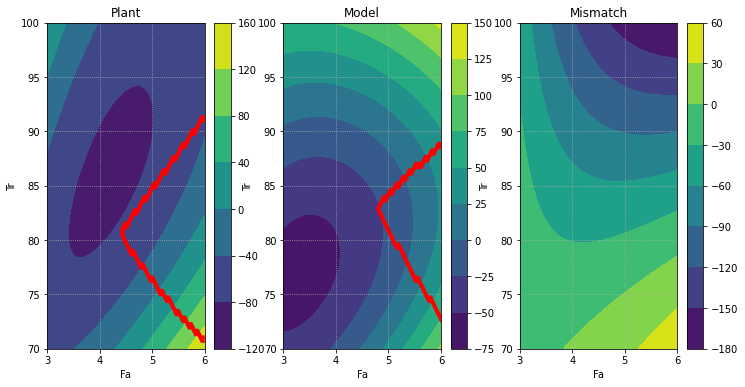

In [8]:
# Plot the decision surface
fig, ax = plt.subplots(1, 3, figsize=(12,6))
def plot_decision_surface(fig, ax, xx, yy, z_f, z_c, title):
    if(z_f is not None):
        ax.contour(xx, yy, z_f, colors='red')
    CS = ax.contourf(xx, yy, z_c, cmap='viridis')
    fig.colorbar(CS, ax=ax)
    ax.set_xlabel('Fa')
    ax.set_ylabel('Tr')
    ax.set_title(title)

plot_decision_surface(fig, ax[0], xx, yy, g_plant, z_plant, 'Plant')
plot_decision_surface(fig, ax[1], xx, yy, g_model, z_model, 'Model')
plot_decision_surface(fig, ax[2], xx, yy, None, z_plant - z_model, 'Mismatch')

fig.show()

From this chart we notice these interesting information:
1. The unconstrained minima of plant and model and very different. Optimizing over the model would definitely result in a sub-optimal operating point.
2. When constraints are added, the optima are located at their intersection. This could lead to unfeasible operation if optimazing over the model, if not properly evaluated beforehand.

Let's have a deeper look at item (2). In order to do that, we should solve the optimization problem described previously, for both the plant and model. The Differential Evolution algorithm will be used, because of it's nice capabilities for handling restrictions and global convergence.

In [4]:
optimizer = ModelBasedOptimizer(ub=ubx, lb=lbx, g=g, solver={'name': 'de', 'params': {'strategy': 'best1bin'}}, backoff=0.0)
f_plant, u_plant ,_ = optimizer.run(plant, [])
f_model, u_model ,_ = optimizer.run(model, [])

print(f'Plant: u*={u_plant}, f*={f_plant}')
print(f'Model: u*={u_model}, f*={f_model}')

Plant: u*=[ 4.38968882 80.6467927 ], f*=-75.81831676487832
Model: u*=[ 4.790182   83.18947581], f*=-26.159822579467345


Although the solution found for both the model and plant are very close, let's see what happens if we apply the input found with the model into the plant. The 'x' represents the model solution, while the "*" the plant optimum.

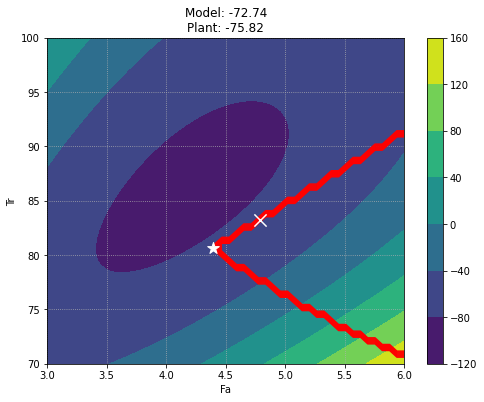

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
model_cost = plant.get_objective(u_model)

plot_decision_surface(fig, ax, xx, yy, g_plant, z_plant, f'Model: {model_cost:.2f}\nPlant: {f_plant:.2f}')

ax.scatter(u_plant[0], u_plant[1], c='w', marker='*', s=150, zorder=5)
ax.scatter(u_model[0], u_model[1], c='w', marker='x', s=150, zorder=5)
fig.show()

Notice that although the solution remained inside the feasible region, it is definitely sub-optimal. It is easy to notice that depending on the model parameters, the optimal solution could easily become unfeasible. Thus, one can see that some sort of adaptation of the model is necessary to ensure convergence to the actual plant optimum, while respecting the process constraints. 

## Real-Time Optimization

RTO systems are capable of iteratively driving the system towards the optimum in spite of plant-model mismatch. The entire system is displayed in the image below:

![RTO System](rto_diagram.png)

Several approaches exist in the literature, and can be classified based on the adaptation strategy they use. The most relevant are the two-step (TS) and modifier adaptation (MA). TS employs as adaptation strategy the update of the model parameters by solving a data reconciliation problem based on measured plant data. On the other hand, modifier adaptation uses plant data to add the so-called modifiers to the cost and constraint functions of the model-based optimization problem. Each method has its pros and cons, and their usage will depend on the process being optimized. 
Here I am going to use first the Modifier Adaptation with Gaussian Processes (GP) scheme.

### Modifier Adaptation with Gaussian Processes
This is a novel technique that leverages GP regression to represent the plant-model mismatch. It removes the need of calculating plant gradients, a requirement for previous MA schemes. The diagram below display how it works in practice:

![MA-GP](rto_magp_diagram.png)

The RTO system is run with the following parameters:
* 5 random feasible sub-optimal operating points
* 30 RTO iterations
* Plant measurements without any noise
* GP regression:
  * Squared-exponential kernel
  * Trained using the last 10 available operating points
  * New data is only incorporated if sufficiently far from the existing data
* Input exponential filter: $\eta = 0.4$

This experiment is repeated 10 times, given the stochastic nature of the RTO system.

Since we know the plant's optimal cost and input signal, we can evalute the system performance based on the relative optimality gap:

$\Delta u\% =  \left\|100 \frac{u - u^{opt}}{u^{opt}} \right\|, \quad \Delta \phi \% =  100 \frac{\phi - \phi^{opt}}{\phi^{opt}} $

Before running the RTO system in closed-loop, first we collect some initialization data. After that, we have to build the two main elements of such system:
* Adaptation Strategy: we use the MA-GP, which is implemented by the `MAGaussianProcesses` class
* Model-based Optimization problem: we need to provide an instance of the `ModifierAdaptationOptimizer` class, using the cost and constraint functions defined in the previous section. Moreover, we must use the approximate model, since in practice we don't know the plant's model.

After that, we pass these objects to the `RTO` class, which will be responsible for running the system in closed loop, as shown in the previous diagrams. Internally, it runs the following steps:

1. Run the model-based optimization problem
2. Filter the calculated optimal input using an exponential filter
3. Apply the input to the plant and collect the necessary measurements
4. Execute the adaptation strategy

All the RTO iteration data is stored in a sqlite database. This makes sure we have everything necessary for analyzing its performance as a whole later. This notebook uses a memory datbase, but one can also use a physical one.

Finally, we can run the RTO system. The last sampled initial operating point is used to start the system.

In [5]:
# load the results
analyzer = ExperimentAnalyzer(DATABASE)
results_ma_de = analyzer.load('MA-GP-DE')
results_ma_sqp = analyzer.load('MA-GP-SQP')

results_processed_ma_de = analyzer.pre_process(results_ma_de, f_plant, u_plant)
results_processed_ma_sqp = analyzer.pre_process(results_ma_sqp, f_plant, u_plant)

results_ma_all = pd.concat([results_processed_ma_de, results_processed_ma_sqp], ignore_index=True)

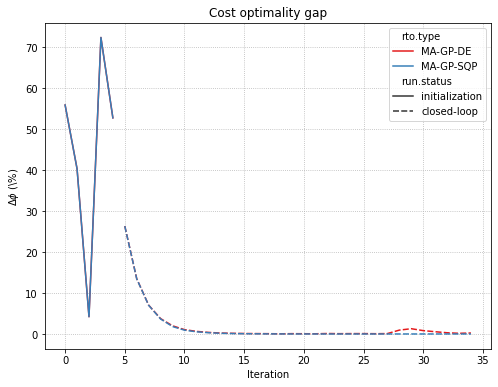

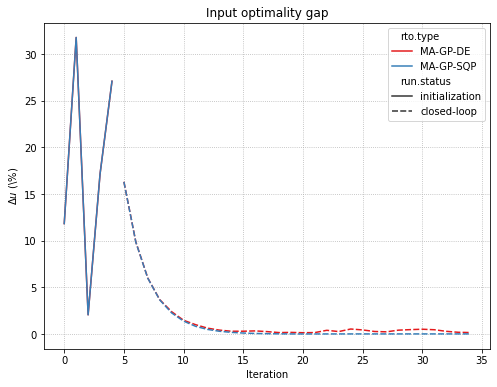

In [6]:
_ = analyzer.plot_by_iteration(results_ma_all, 'dPhi', '$\Delta \phi$ (\%)', 'Cost optimality gap',style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_ma_all, 'du', '$\Delta u$ (\%)', 'Input optimality gap',style='run.status', hue='rto.type')

It is also possible to look at the operating points calculated at each RTO iteration. The initial dataset is represented by the pink diamonds, while the closed-loop iterations are in black. Notice that the system rapidly converges to the plant optimum.

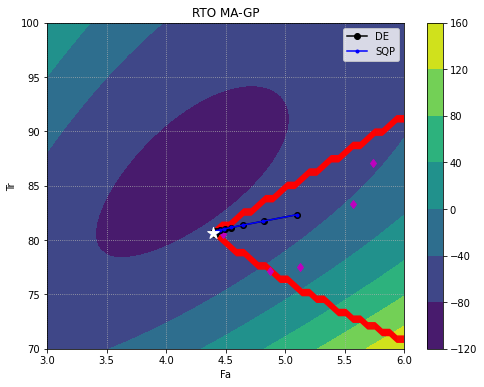

In [10]:
def plot_convergence_comparison_surface(results_1, results_2, title, legend, initial_data_size=5):
    fig, ax = plt.subplots(figsize=(8,6))

    plot_decision_surface(fig, ax, xx, yy, g_plant, z_plant, title)
    u_rto_1 = np.stack(results_1['u'], axis=0)
    u_rto_2 = np.stack(results_2['u'], axis=0)

    u_rto_init = u_rto_1[:initial_data_size, :]
    u_rto_1 = u_rto_1[initial_data_size:, :]
    u_rto_2 = u_rto_2[initial_data_size:, :]

    ax.scatter(u_plant[0], u_plant[1], c='w', marker='*', s=150, zorder=6)
    ax.plot(u_rto_init[:,0], u_rto_init[:,1], 'md', zorder=4)
    line1, = ax.plot(u_rto_1[:,0], u_rto_1[:,1], 'ko-', zorder=4)
    line2, = ax.plot(u_rto_2[:,0], u_rto_2[:,1], 'b.-', zorder=5)
    ax.legend((line1, line2), legend)

    fig.show()

plot_convergence_comparison_surface(results_processed_ma_de, results_processed_ma_sqp, 'RTO MA-GP', ('DE','SQP'))

### Effect of Noise

The results above are for the scenario where we have no noise in the plant measuremets. Since this is not the reality, an interesting test is to check how it can impact the RTO performance. For that, we consider a 0.01 additive gaussian noise, but using the same parameters as the previous system.

In [11]:
# load the results
results_ma_de = analyzer.load('MA-GP-DE+noise')
results_ma_sqp = analyzer.load('MA-GP-SQP+noise')

results_processed_ma_de_noise = analyzer.pre_process(results_ma_de, f_plant, u_plant)
results_processed_ma_sqp_noise = analyzer.pre_process(results_ma_sqp, f_plant, u_plant)

results_ma_noise_all = pd.concat([results_processed_ma_de_noise, results_processed_ma_sqp_noise], ignore_index=True)

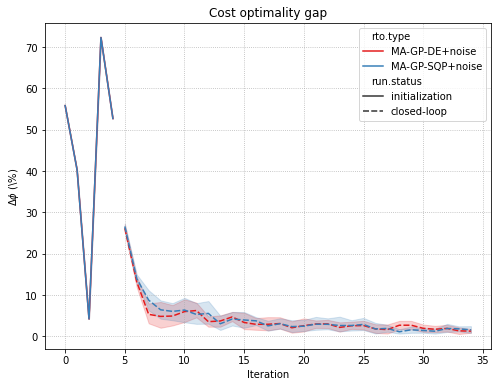

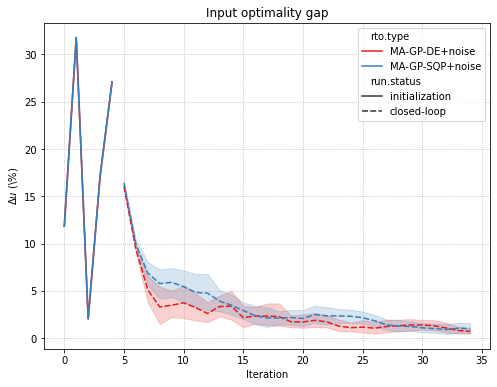

In [12]:
_ = analyzer.plot_by_iteration(results_ma_noise_all, 'dPhi', '$\Delta \phi$ (\%)', 'Cost optimality gap',style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_ma_noise_all, 'du', '$\Delta u$ (\%)', 'Input optimality gap',style='run.status', hue='rto.type')

### Using different initial data points
We start to see more variation, but results are still equivalent for both cases. What if we initialized the system at different starting points?

In [14]:
# load the results
results_ma_de = analyzer.load('MA-GP-DE+noise-datasets')
results_ma_sqp = analyzer.load('MA-GP-SQP+noise-datasets')

results_processed_ma_de_noise_df = analyzer.pre_process(results_ma_de, f_plant, u_plant)
results_processed_ma_sqp_noise_df = analyzer.pre_process(results_ma_sqp, f_plant, u_plant)

results_ma_noise_datasets_all = pd.concat([results_processed_ma_de_noise_df, results_processed_ma_sqp_noise_df], ignore_index=True)

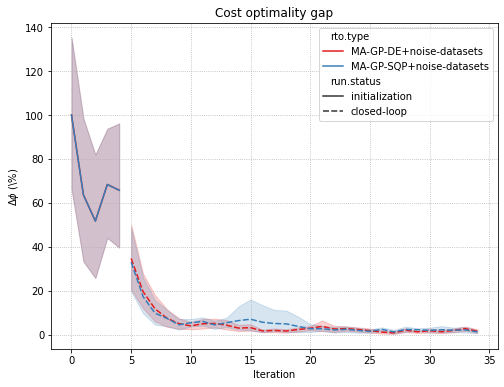

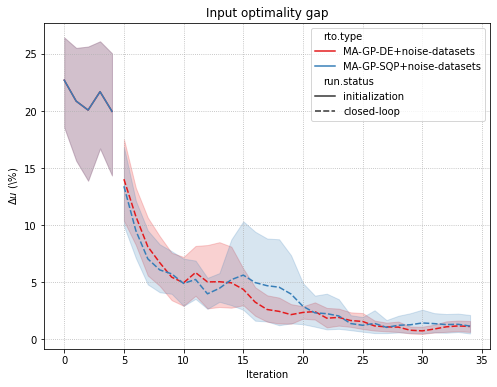

In [15]:
_ = analyzer.plot_by_iteration(results_ma_noise_datasets_all, 'dPhi', '$\Delta \phi$ (\%)', 'Cost optimality gap',style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_ma_noise_datasets_all, 'du', '$\Delta u$ (\%)', 'Input optimality gap',style='run.status', hue='rto.type')

As seen in the images above, for the Williams-Otto problem, there is a very small effect on using different points for initialiazing the RTO system. Although there is some variation introduced by the measuremente noise,the system easily converges under both optimization algorithms. It is important to notice that this may not be entirely true if the problem exhibits more non-convexity, as investigated in [YY].

## EIC acquisition function

There is a clear link between RTO and Bayesian optimization. Both problems try to optimize and unknown and expensive-to-evaluate function by sampling it according to some heuristics. The main difference lies in the fact that the Bayesian framework is purely data-drive, while in RTO we have a model that, although imperfect, captures the main behavior of the unknown function. Notice that this works as some sort of *prior* knowledge, which in the Bayesian frameork could be historical samples of the function to be optimized, for example.

Considering the MA-GP scheme, one can see that the RTO system learns the plant-model mismatch using GPs and the prior knowledge of the model is used to drive plant optimization. In the Bayesian framework, this is achieved with the use of so-called acquisition functions. Therefore, one could ask the following question: what if we included the acquisition function in RTO procedure? Could this improve the system's performance? 

This was already done by [XX], which applied an EI acquisition to the objective, but used derivative-free and trust-region concepts to handle constrained problems. The idea behind this is to reduce or increase the trust-region size based on thje discrepancy between model estimations and plant measurements. But, one can clearly see that embedding a fully constrained Bayesian framework could be easily achieved. We can change the model-based optimization problem to use the EIC acquisition function, since we have GPs already trained on the constraints mismatch. This turns our constrained problem into a unconstrained one, using a barrier-like objective function.

First, let's run the optimization problem with the EIC acquisition function, using the same default parameters for GP learning. We also run MA-GP as a baseline to compare the results. The last sampled initial operating point is used to start the system. For now, only the noiseless case is considered, to avoid unexpected effects.

### Optimizer Choice

In [16]:
# load the results
analyzer = ExperimentAnalyzer(DATABASE)
results_bay_de = analyzer.load('MA-GP-Bayesian-DE')
results_bay_sqp = analyzer.load('MA-GP-Bayesian-SQP')

results_processed_bay_de = analyzer.pre_process(results_bay_de, f_plant, u_plant)
results_processed_bay_sqp = analyzer.pre_process(results_bay_sqp, f_plant, u_plant)

results_bayes_all = pd.concat([results_processed_bay_de, results_processed_bay_sqp], ignore_index=True)

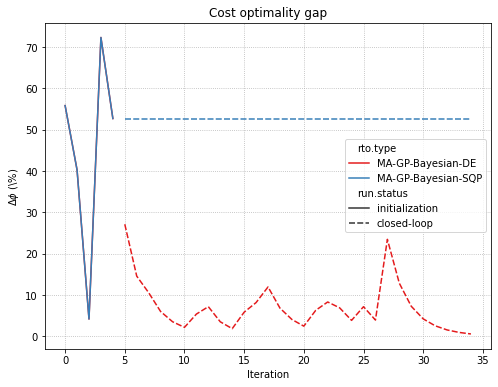

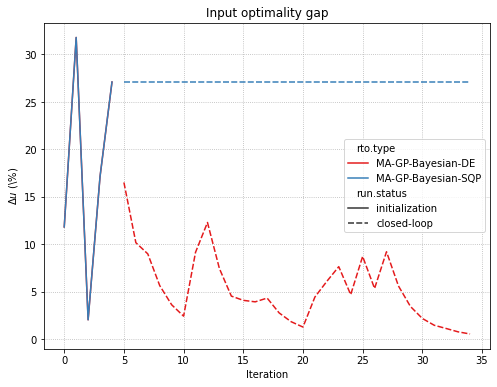

In [17]:
_ = analyzer.plot_by_iteration(results_bayes_all, 'dPhi', '$\Delta \phi$ (\%)', 'Cost optimality gap', style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_bayes_all, 'du', '$\Delta u$ (\%)', 'Input optimality gap',style='run.status', hue='rto.type')

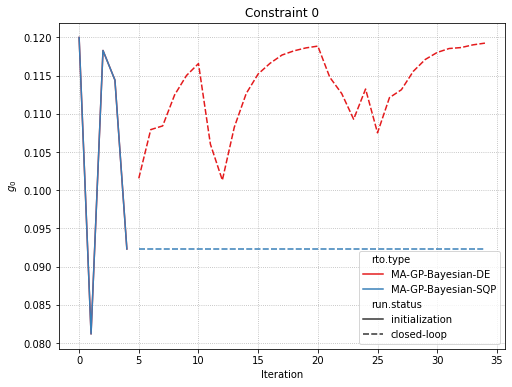

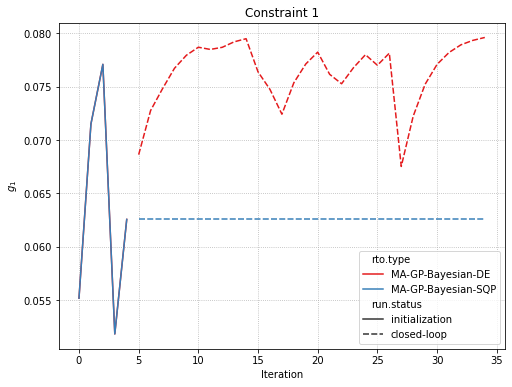

In [18]:
_ = analyzer.plot_by_iteration(results_bayes_all, 'g_0', '$g_0$', 'Constraint 0',style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_bayes_all, 'g_1', '$g_1$', 'Constraint 1',style='run.status', hue='rto.type')

### Comparison with MA-GP

As seen before, SQP is unable to even find properly optimizer the EIC function. Therefore, we continue the remainder of this tutorial considering the DE algorithm as the default optimizer. Now, we comparte the results classic MA-GP scheme and with EIC acquisition function, considering the same experimental conditions.

Below the results for the cost and input optimality gap are displayed. Notice that using the proposed Bayesian framework, we achieve similar results as the MA-GP baseline. However, the Bayesian approach presents more variability during the optimization steps, we could be related to the way we penalize the constraints violations. As seen previously, the optimal point will lie exactly at the intersection of two constraints, which poses a challenge for the RTO system. 

Another angle is to understand how the EIC acquisition function balances exploration and explotation. Maybe there is some exploitation happening when it shouldn't.

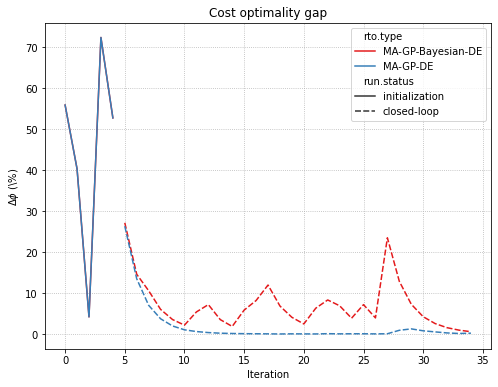

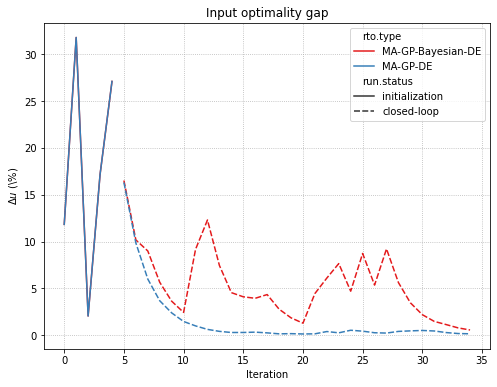

In [19]:
results_bayes_magp = pd.concat([results_processed_bay_de, results_processed_ma_de], ignore_index=True)

_ = analyzer.plot_by_iteration(results_bayes_magp, 'dPhi', '$\Delta \phi$ (\%)', 'Cost optimality gap', style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_bayes_magp, 'du', '$\Delta u$ (\%)', 'Input optimality gap',style='run.status', hue='rto.type')

Having a further look at the constraints, we can observer an interesting situation: using the EIC objective function, there is a high penalty for violating constraints. Whenever any of them are violated, there next solution found is biased towards this result, causing the system to be driven away from the unfeasible region. This is an interesting property, but it can prevent it from converging to the acutal plant optimum, specially if it lies at non-empty set of active constraints.

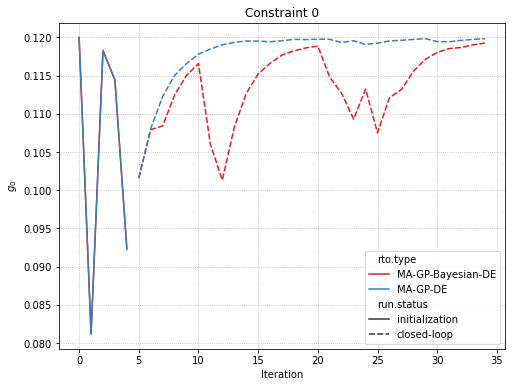

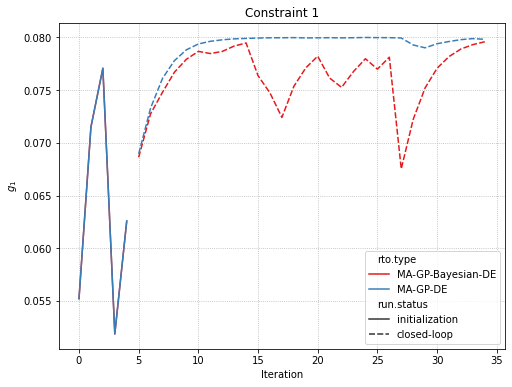

In [20]:
_ = analyzer.plot_by_iteration(results_bayes_magp, 'g_0', '$g_0$', 'Constraint 0',style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_bayes_magp, 'g_1', '$g_1$', 'Constraint 1',style='run.status', hue='rto.type')

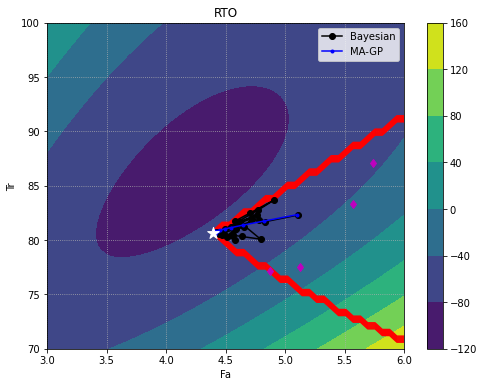

In [21]:
plot_convergence_comparison_surface(results_processed_bay_de, results_processed_ma_de, 'RTO', ('Bayesian','MA-GP'))

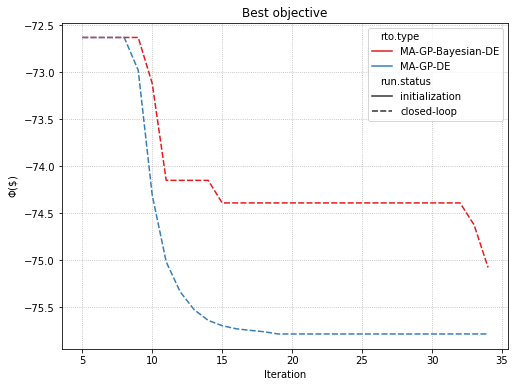

In [22]:
_ = analyzer.plot_by_iteration(results_bayes_magp, 'best_plant_objective', '$\Phi (\$)$', 'Best objective',style='run.status', hue='rto.type')

### EIC initialization

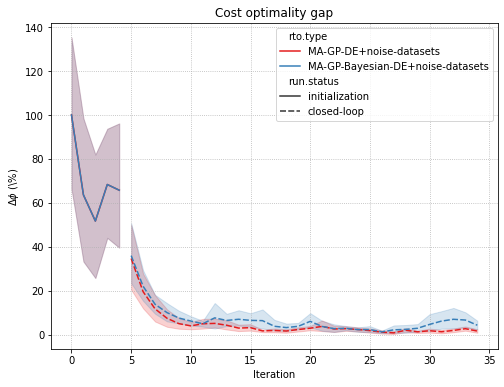

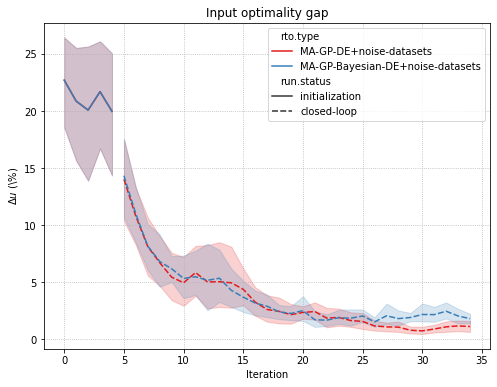

In [23]:
results_bay_datasets = analyzer.load('MA-GP-Bayesian-DE+noise-datasets')
results_bay_processed_datasets = analyzer.pre_process(results_bay_datasets, f_plant, u_plant)

results_bayes_magp_datasets = pd.concat([results_processed_ma_de_noise_df, results_bay_processed_datasets], ignore_index=True)

_ = analyzer.plot_by_iteration(results_bayes_magp_datasets, 'dPhi', '$\Delta \phi$ (\%)', 'Cost optimality gap', style='run.status', hue='rto.type')
_ = analyzer.plot_by_iteration(results_bayes_magp_datasets, 'du', '$\Delta u$ (\%)', 'Input optimality gap',style='run.status', hue='rto.type')

### Investigating the EIC decision surface

In [24]:
def get_grid_predictions(models, xx, yy):
    # unpack stuff
    fobj = models['f']
    scaler = models['gp_scaler']
    constraint0 = models['g_0']
    constraint1 = models['g_1']
    
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    # make predictions for the grid
    cost = np.array([model.get_objective(x) + fobj.predict(scaler.transform(x.reshape(1,-1))) for x in grid])
    g_0 = np.array([model.get_constraints(x)[0] + constraint0.predict(scaler.transform(x.reshape(1,-1))) for x in grid])
    g_1 = np.array([model.get_constraints(x)[1] + constraint1.predict(scaler.transform(x.reshape(1,-1))) for x in grid])

    # reshape the predictions back into a grid
    zz_cost = cost.reshape(xx.shape)
    zz_g0 = g_0.reshape(xx.shape)
    zz_g1 = g_1.reshape(xx.shape)

    return zz_cost, zz_g0, zz_g1

def plot_gp_surface(fig, ax, xx, yy, z_f, title):
    CS = ax.contour(xx, yy, z_f)
    fig.colorbar(CS, ax=ax)
    ax.set_xlabel('Fa')
    ax.set_ylabel('Tr')
    ax.set_title(title)

def plot_gp_predictions(ax, i, gp_iterations, xx, yy, title, initial_data_size=5):
    f_gp, g0_gp, g1_gp = get_grid_predictions(gp_iterations[initial_data_size + i],xx,yy)
    g_gp = (g1_gp < g1)&(g0_gp < g0)
    plot_decision_surface(fig, ax, xx, yy, g_gp, f_gp, title)

In [31]:
def get_eic_grid(models, xx, yy, f_best):
    # unpack stuff
    fobj = models['f']
    scaler = models['gp_scaler']
    constraint0 = models['g_0']
    constraint1 = models['g_1']
    
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    # make predictions for the grid
    ei = []
    eic = []
    g0_probs = []
    g1_probs = []

    for x in grid:
        xs = scaler.transform(x.reshape(1,-1))
        model_obj = model.get_objective(x)
        model_g = model.get_constraints(x)

        adaptation = Bunch(modifiers=[fobj.predict(xs, return_std=True), constraint0.predict(xs, return_std=True), constraint1.predict(xs, return_std=True)])
        ei_f = ModelBasedBayesianOptimizer.ei_acquisition(model_obj, adaptation, f_best)

        ei.append(ei_f)
        probs = ModelBasedBayesianOptimizer.constraint_probability(g, model_g, adaptation)
        eic.append(ei_f*np.prod(probs))
        g0_probs.append(probs[0])
        g1_probs.append(probs[1])


    # reshape the predictions back into a grid
    zz_ei = np.array(ei).reshape(xx.shape)
    zz_g0 = np.array(g0_probs).reshape(xx.shape)
    zz_g1 = np.array(g1_probs).reshape(xx.shape)
    zz_eic = np.array(eic).reshape(xx.shape)

    return zz_ei, zz_g0, zz_g1, zz_eic

def plot_eic_grid(ax, i, best_solutions, gp_iterations, xx, yy, title, initial_data_size=5):
    fbest = best_solutions.iloc[initial_data_size + i]
    f_gp, g0_gp, g1_gp, eic = get_eic_grid(gp_iterations[initial_data_size + i],xx,yy,fbest)
    plot_decision_surface(fig, ax[0], xx, yy, None, f_gp, 'EI')
    plot_decision_surface(fig, ax[1], xx, yy, None, g1_gp*g0_gp, '$p(c(x) <= 0)$')
    plot_decision_surface(fig, ax[2], xx, yy, None, eic, 'EIC')

def plot_eic_iterations(iterations, results, gp_models, initial_data_size=5):
    fig, ax = plt.subplots(3,3,figsize=(16,16))
    for i, itertrain in enumerate(iterations):
        plot_eic_grid(ax[i,:], itertrain, results['best_plant_objective'], gp_models,xx,yy, f'Iter. {itertrain}')
        #plot_gp_predictions(ax[i,0], itertrain, gp_models, xx,yy, f'Iter. {itertrain}')

        u_eic = results['u'].iloc[initial_data_size + itertrain]
        
        ax[i,0].scatter(u_plant[0], u_plant[1], c='r', marker='*', s=150, zorder=6)
        ax[i,1].scatter(u_plant[0], u_plant[1], c='r', marker='*', s=150, zorder=6)
        ax[i,2].scatter(u_plant[0], u_plant[1], c='r', marker='*', s=150, zorder=6)

        ax[i,0].scatter(u_eic[0], u_eic[1], c='r', marker='x', s=150, zorder=6)
        ax[i,1].scatter(u_eic[0], u_eic[1], c='r', marker='x', s=150, zorder=6)
        ax[i,2].scatter(u_eic[0], u_eic[1], c='r', marker='x', s=150, zorder=6)
        
    fig.show()

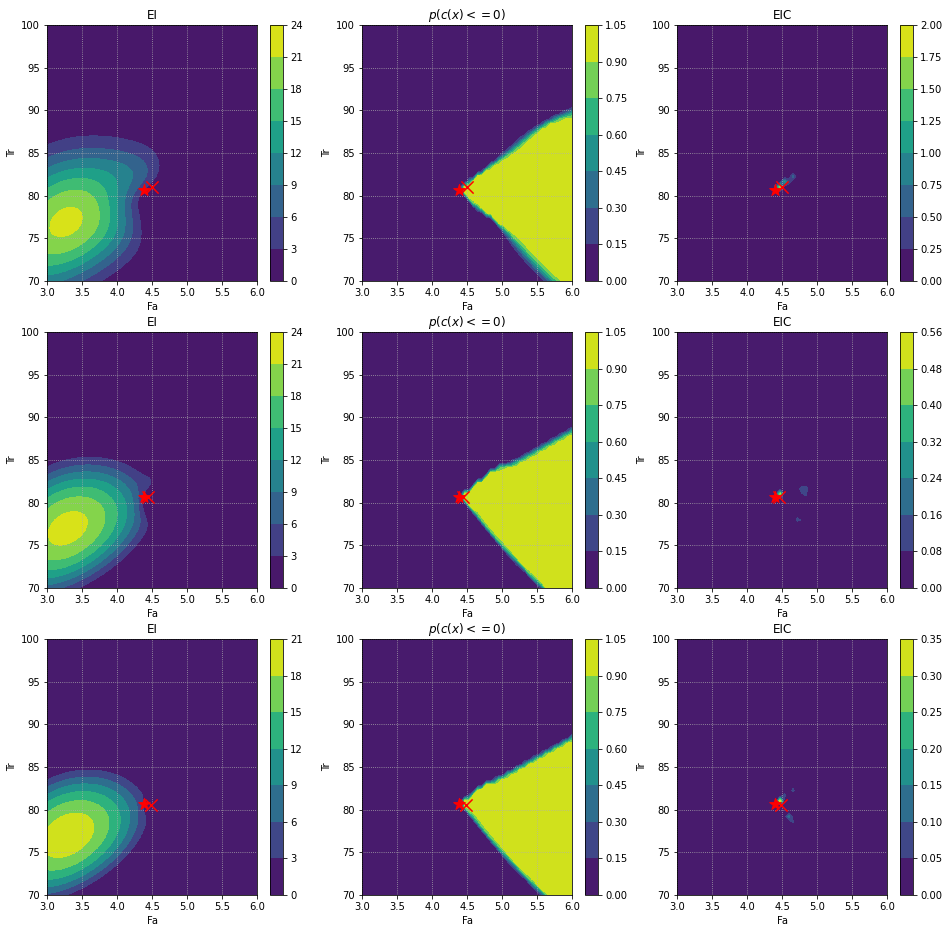

In [32]:
iterations = [5,15,25]
gp_results_bay_de = [analyzer.load_run_models(run_id) for run_id in results_processed_bay_de['run.id']]
plot_eic_iterations(iterations, results_processed_bay_de, gp_results_bay_de)